# Part2 Implementing the LoG scale blob detector (60 points):
In an iPython notebook logscale.ipynb, import the following

~~~
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
~~~

## Must do
- Implement the Laplacian of `Gaussian blob detector including scale space tracking`. 
- First write a function `LoG(sigma=1,size=19)` :
    1. first argument is the parameter of the Gaussian kernel 
    2. second argument is the overall image size of the filter (here by default 19x19 pixels). 
    3. The function should return a numpy array with the filter values. At each pixel (x,y), the LoG has the value of (note, that the values have to be CENTERED in the window!!)
    4. Insert code that shows LoG filters for `sigmas from 1 to 10` in steps of 1 with a size of 19 pixels.

$$\textrm{LoG}(x,y)=-\frac{1}{\pi \sigma^4}(1-\frac{x^2+y^2}{2\sigma^2})e^{-\frac{x^2+y^2}{2\sigma^2}}$$

- Insert another function called `filterImg(img,fil)`:
    1. performs a convolution of img with fil and returns the filtered image as its return value. MAKE SURE that the return image has the SAME size as the input image img!!!

- Insert another function called `trackScale(img,sigmas,size,threshold)`: 
    1. Creates len(sigmas) LoG filters with the sigmas in the array for the specified size
    2. Filters img with each LoG filter
    3. For each pixel in the stack of filtered images, finds the maximum value and stores this in a return array called totScale
    4. Plots the input picture img with overlays of the SCALED blobs that were found similar to the pictures in class on slides 79,84

- Use the following picture (again, you may need to convert to PNG so you can read it in with matplotlib code) ([LINK](https://img1.southernliving.timeinc.net/sites/default/files/styles/4_3_horizontal_inbody_900x506/public/image/2018/07/main/the_sunflower_fields_at_neuse_river_greenway_trail.jpg?itok=ZOlvAuIg&1532035249))

- Insert code that uses good parameters for `sigmas, size, and threshold` so that you can find as many sunflower “blobs” as possible.

In [ ]:
# Import needed libraries
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from PIL import Image

%matplotlib inline

In [ ]:
# Define function to convert an rgb image to gray scale image
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [ ]:
# change JPEG to PNG
img_name = 'sunflower'
img_gif =  Image.open(img_name+'.jpeg')
img_gif.save(img_name+".png",'png')

shape : (640, 960, 3) 


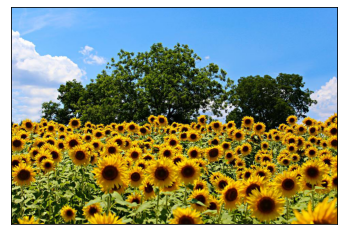

In [ ]:
img = plt.imread(img_name+'.png')
print('shape : {} '.format(img.shape))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

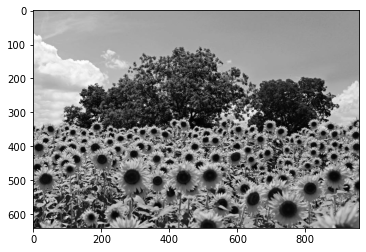

In [ ]:
# Show the target image to work on
img = rgb2gray(img)
plt.imshow(img, cmap='gray')

Following site(https://math.stackexchange.com/questions/486303/normalized-laplacian-of-gaussian) states that:
> In order to make the Laplacian of Gaussian operator invariant to scales, it is always said to normalize LoG by multiplying $σ^2$,

Therefore, we have added normalization for out LoG operator:

$$\operatorname{LoG}_\text{normalized}(x,y) = \sigma^2\cdot \operatorname{LoG}(x,y) = \frac{1}{\pi\sigma^2}\left(\frac{x^2+y^2}{2\sigma^2} - 1\right)e^{-\frac{x^2+y^2}{2\sigma^2}}.$$


In [ ]:
def LoG(sigma=1, size=19):
    '''
    Information: Function to return a LoG filter used for extracting features in an image
    Arguments
        sigma: sigma value used in LoG
        size: size of the kernel for LoG convolution
    '''
    ws = size
    
    # Base filter
    fil = np.zeros((2*ws+1, 2*ws+1))
    
    # Fill the filter to make LoG filter
    for i in range(-ws, ws+1):
        for j in range(-ws, ws+1):
            tmp = (i**2+j**2)/(2*sigma**2)
            fil[i+ws, j+ws] = -1/(np.pi*np.power(sigma, 4))*(1-tmp)*np.exp(-tmp)*(sigma**2)
            
    return fil

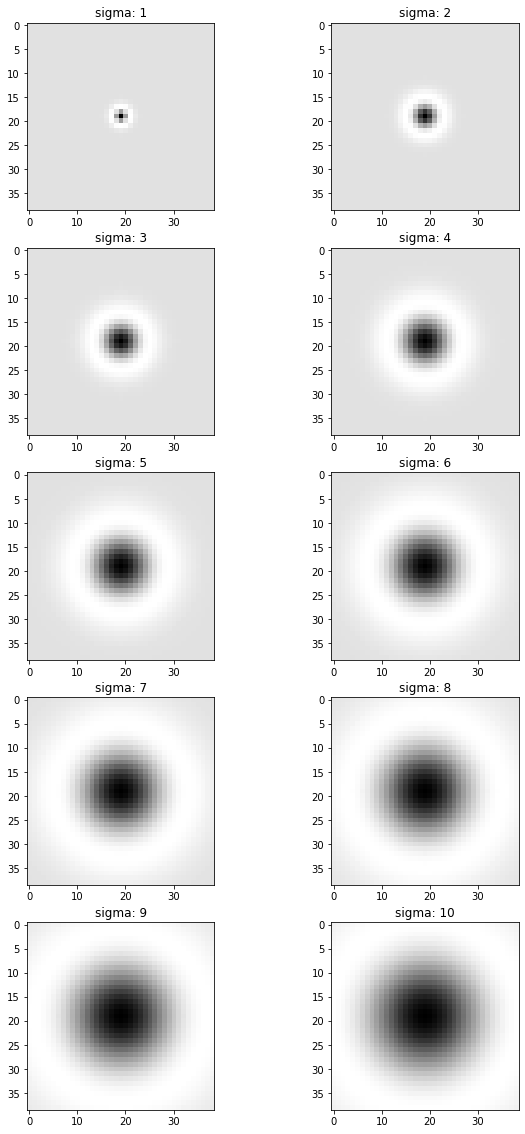

In [ ]:
# -------------------------------------------------------------------
#  Plotting sample LoG kernels of different sigma values of size=19
# -------------------------------------------------------------------
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for sigma_val in range(0, 10):
    r = sigma_val // 2
    c = sigma_val % 2
    log_filter = LoG(sigma=sigma_val+1, size=19)
    axes[r][c].imshow(log_filter, cmap='gray')
    axes[r][c].set_title(f"sigma: {sigma_val+1}")

In [ ]:
def LoG(sigma=1, size=19):
    '''
    Information: Function to return a LoG filter used for extracting features in an image
    Arguments
        sigma: sigma value used in LoG
        size: size of the kernel for LoG convolution
    '''
    
    # -----------------------------------------------------------------------
    #   Notes;
    #   Through some experiments,
    #   we found out it works best to get the 'size' bigger along with sigma,
    #   so we use size * sigma instead of using size alone.
    #   This lets us use the parameter 'size' of a smaller value instead.
    # -----------------------------------------------------------------------
    ws = size * sigma
    ws = ws if ws % 2 != 0 else ws - 1
    
    # Base filter
    fil = np.zeros((2*ws+1, 2*ws+1))
    
    # Fill the filter to make LoG filter
    for i in range(-ws, ws+1):
        for j in range(-ws, ws+1):
            tmp = (i**2+j**2)/(2*sigma**2)
            fil[i+ws, j+ws] = -1/(np.pi*np.power(sigma, 4))*(1-tmp)*np.exp(-tmp)*(sigma**2)
            
    return fil

In [ ]:
def filterImg(img=None, fil=None):
    '''
    Information: Performs a convolution of img with fil and returns the filtered image as its return value.
    Arguments
        img: Input image to apply filter.
        fil : Filter to be used for convolutions.
    '''
    kernel = fil.astype(float)
    
    # this holds the end result
    width = int((kernel.shape[1]-1)/2)
    height = int((kernel.shape[0]-1)/2)
    
    # do reflective padding which is the default padding used in cv2.filter2D
    img = np.pad(img, ((width//2, width//2), (height//2, height//2)), 'reflect')
    filtered = np.zeros_like(img)
    
    # do the filtering
    for i in range(height, img.shape[1]-height):
        for j in range(width, img.shape[0]-width):
            filtered[j,i] = np.sum(kernel*img[j-width:j+width+1, i-height:i+height+1])
            
    # Remove zero-padded areas -> same size output
    filtered = filtered[int((width)/2):-int((width)/2), int((height)/2):-int((height-1)/2)]
    
    return filtered

def  trackScale(img=None, sigmas=None, size=19, threshold=0.1):
    '''
    1) Creates len(sigmas) LoG filters with the sigmas in the array for the specified size
    2) Filters img with each LoG filter
    3) For each pixel in the stack of filtered images, finds the maximum value and stores this in a return array called totScale
    4) Plots the input picture img with overlays of the SCALED blobs that were found similar to the pictures in class on slides 79,84
    '''
    result_images = [] # Array to store result images
    
    # Perform convolutions on given image using each sigma value
    for sigma in sigmas:
        print(f"Working on sigma: {sigma}")
        filter_log = LoG(sigma=sigma, size=size)
        image = filterImg(img=img, fil=filter_log)
        result_images.append(image)
    
    # to numpy for slicing afterwards
    result_images = np.array(result_images)
    
    # Find blobs from result_images
    totScale = []
    for h in range(1, img.shape[0]):
        for w in range(1, img.shape[1]):
            # slice with 1x1 pixels to get the local maxima
            sliced = result_images[:, h:h+1, w:w+1]
            
            # finds the maximum value to store in totScale
            log_result = np.amax(sliced)
            if log_result >= threshold: # threshold used for finding blobs
                z, x, y = np.unravel_index(sliced.argmax(), sliced.shape) # get local coordinates
                totScale.append((h+x-1, w+y-1, z)) # map the local coordinates to the original image
    
    return totScale

In [ ]:
# ------------------------------------------------------
#   NOTES;
#    We found that the maximum value of sigmas should be big enough
#    when applying them in stepped-array fashion,
#    or big blobs may not be well detected.
# ------------------------------------------------------
sigmas = list(range(1, 16))

# ------------------------------------------------------
#   Detect blobs
#   Through trial and errors, we found the combination below the best/effective parameters for detecting blobs
#   sigmas    : 1 to 15 with step size=1
#   size      : 5
#   threshold : 0.24
# ------------------------------------------------------
blobs_detected = trackScale(img=img, sigmas=sigmas, size=5, threshold=0.24)

# Get unique values
blobs_detected_unique = list(set(blobs_detected))

# Get rid of zero-sized blobs
blobs_detected_unique = [blob for blob in blobs_detected_unique if blob[-1] > 0]

Working on sigma: 1
Working on sigma: 2
Working on sigma: 3
Working on sigma: 4
Working on sigma: 5
Working on sigma: 6
Working on sigma: 7
Working on sigma: 8
Working on sigma: 9
Working on sigma: 10
Working on sigma: 11
Working on sigma: 12
Working on sigma: 13
Working on sigma: 14
Working on sigma: 15


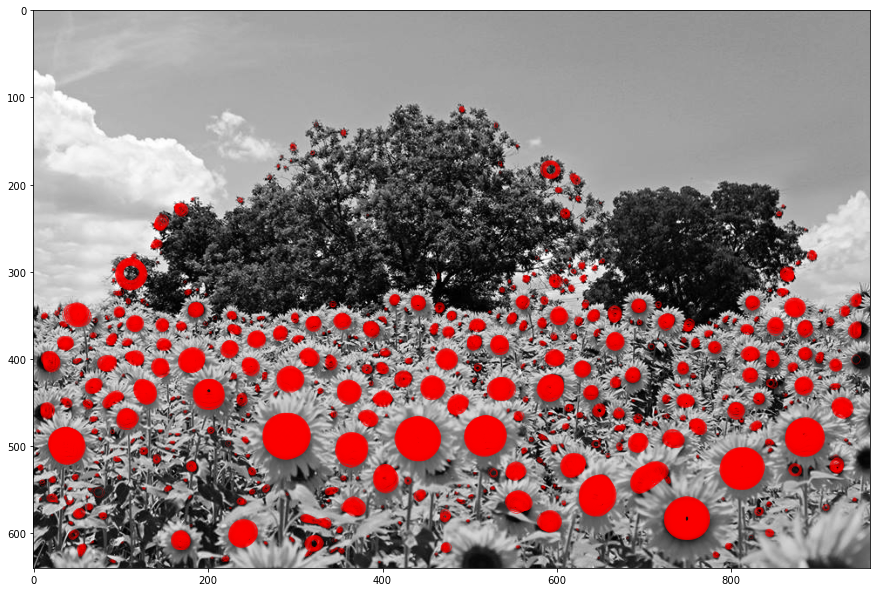

In [ ]:
# ----------------------------------
#  Plot the blob detection result
# ----------------------------------
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, cmap='gray')

# Overlay blobs on the image and show
for y, x, val in blobs_detected_unique:
    blob = plt.Circle((x, y), val, color='red', linewidth=0.2, fill=False)
    ax.add_patch(blob)

ax.plot()
plt.show()